# Global Investment Behavior During Uncertainty: Do Economies Favor Safer Bets or Scalable Risk?


## Project 1

### Introduction

Periods of economic uncertainty—whether due to financial crises, pandemics, or geopolitical shocks—often lead investors to reassess their strategies. Venture capital, as one of the most risk-tolerant investment mechanisms, offers a unique lens into how economies navigate uncertainty: do investors seek refuge in safer, well-established sectors, or double down on high-risk, high-reward ventures that promise scalability? This project addresses that question using the Crunchbase startup investments dataset (Cirtautas, 2020), combined with external scraped data on global compensation trends and startup sectors.

The existing literature provides mixed insights. During downturns, some evidence suggests a retreat into capital-preserving investments (Rajan, 2010), while others highlight counter-cyclical opportunities in innovative startups (Nanda & Rhodes-Kropf, 2013). Gompers and Lerner (2001) describe the venture capital ecosystem as highly cyclical, yet surprisingly adaptive, often pivoting toward sectors like biotech or fintech in times of stress. Recent studies by Samila and Sorenson (2011) and Chemmanur et al. (2020) find that investor behavior shifts significantly during uncertainty, but the balance between risk-aversion and risk-seeking is sector- and region-dependent.

This study contributes to that conversation by modeling how startup investment varies across sectors, regions, and funding stages during uncertain periods. We examine whether capital allocation reflects a flight to "safe bets" (e.g., health, infrastructure) or an appetite for "scalable risk" (e.g., AI, fintech). Using exploratory analysis, regression modeling, and machine learning (regression trees and random forests), we test whether investor preferences lean toward safety or scalability under macroeconomic stress. Additionally, we enrich our dataset through web scraping to contextualize economic conditions and sector dynamics, offering a real-time economic layer to the analysis.

In [83]:
import pandas as pd
import numpy as np

from IPython.display import display

In [84]:
# %pip install qeds
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
import seaborn as sns
import statsmodels.formula.api as smf
import statsmodels.api as sm
from sklearn.ensemble import RandomForestRegressor

In [85]:
objects = pd.read_csv("/Users/zzybollar/Downloads/archive/objects.csv")
funds = pd.read_csv("/Users/zzybollar/Downloads/archive/funds.csv")
offices = pd.read_csv("/Users/zzybollar/Downloads/archive/offices.csv")
investments = pd.read_csv("/Users/zzybollar/Downloads/archive/investments.csv")
ipos = pd.read_csv("/Users/zzybollar/Downloads/archive/ipos.csv")
funding_rounds = pd.read_csv("/Users/zzybollar/Downloads/archive/funding_rounds.csv")
milestones = pd.read_csv("/Users/zzybollar/Downloads/archive/milestones.csv")
relationships = pd.read_csv("/Users/zzybollar/Downloads/archive/relationships.csv")

/var/folders/lh/v36j2zlj0t9_xqpxcj3l9qfw0000gn/T/ipykernel_43512/849428731.py:1: DtypeWarning: Columns (3,7,9,10,17,18,21,22,23,25,26,29,30,37) have mixed types. Specify dtype option on import or set low_memory=False.
  objects = pd.read_csv("/Users/zzybollar/Downloads/archive/objects.csv")


In [86]:
inflation_interest_unemployment = pd.read_csv("/Users/zzybollar/Downloads/archive/inflation interest unemployment.csv")

In [87]:
macro_data = pd.read_csv("/Users/zzybollar/Downloads/archive/economicdata2000-2013.csv")
macro_data.columns = macro_data.iloc[3]
macro_data = macro_data.iloc[4:].reset_index(drop=True)

macro_data.head()

3,NaN,Year,ISO_Code,Countries,Economic Freedom Summary Index,Rank,Quartile,Government consumption,data,Transfers and subsidies,...,Bureacracy costs,Impartial Public Administration,Tax compliance,Business regulations,Market openness,Business Permits,Distorton of the business environment,Freedom to enter markets and compete,Regulation,Area 5 Rank
0,NaN,2013,AGO,Angola,4.84,151,4,1.02,36.54,8.25,...,1.56,2.72,4.67,2.92,2.26,7.61,1.25,3.70,4.18,157
1,NaN,2013,ALB,Albania,7.39,45,2,8.17,12.21,7.07,...,6.00,6.00,3.00,4.99,6.82,7.19,6.25,6.75,6.94,65
2,NaN,2013,ARE,United Arab Emirates,7.09,60,2,4.59,24.41,8.52,...,9.33,6.62,9.93,8.22,8.04,10.00,3.75,7.26,7.89,18
3,NaN,2013,ARG,Argentina,4.88,149,4,5.75,20.44,4.93,...,4.22,6.68,3.98,4.25,4.76,5.35,2.50,4.20,5.21,135
4,NaN,2013,ARM,Armenia,7.31,49,2,8.22,12.04,8.00,...,5.78,4.48,5.70,5.11,5.60,9.56,5.00,6.72,6.98,61


### Data merging and cleaning

In [88]:
macro_data = macro_data.rename(columns={"Year": "year"})
macro_data['year'] = macro_data['year'].astype(int)
macro_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2310 entries, 0 to 2309
Data columns (total 82 columns):
 #   Column                                                Non-Null Count  Dtype  
---  ------                                                --------------  -----  
 0   nan                                                   0 non-null      float64
 1   year                                                  2310 non-null   int64  
 2   ISO_Code                                              2310 non-null   object 
 3   Countries                                             2310 non-null   object 
 4    Economic Freedom Summary Index                       2246 non-null   object 
 5   Rank                                                  2246 non-null   object 
 6   Quartile                                              2246 non-null   object 
 7   Government consumption                                2061 non-null   object 
 8   data                                                  2061

In [89]:
objects.rename(columns={'id':'funded_object_id'}, inplace=True)

In [90]:
df = investments.merge(objects, on='funded_object_id')

In [91]:
A=pd.read_csv("/Users/zzybollar/Downloads/archive/funding_rounds.csv")
A.drop(['id', 'funding_round_id', 'funding_round_code', 'raised_amount', 'raised_currency_code', 
        'pre_money_valuation_usd', 'pre_money_valuation', 'pre_money_currency_code', 
        'post_money_valuation_usd', 'post_money_currency_code', 'participants', 
        'is_first_round', 'is_last_round', 'source_url', 'source_description', 'created_by', 
        'updated_at', 'created_at'], axis='columns', inplace=True)
A.rename(columns={'object_id':'funded_object_id'}, inplace=True)

In [92]:
df2 = df.merge(A, on='funded_object_id')
df2.drop(['created_by', 'first_milestone_at', 'last_milestone_at', 
          'last_investment_at'], axis='columns', inplace=True)

In [93]:
df2 = df2[~(df2['country_code'].isnull() | df2['description'].isnull() | df2['funded_at'].isnull() | df2['founded_at'].isnull())]

In [94]:
df2 = df2[~(df2['category_code'].isnull())]
df2=df2.drop_duplicates()
df2

,id,funding_round_id,funded_object_id,investor_object_id,created_at_x,updated_at_x,entity_type,entity_id,parent_id,name,...,funding_rounds,funding_total_usd,milestones,relationships,created_at_y,updated_at_y,funded_at,funding_round_type,raised_amount_usd,post_money_valuation
0,1,1,c:4,f:1,2007-07-04 04:52:57,2008-02-27 23:14:29,Company,4,NaN,Digg,...,4,45000000.0,8,57,2007-05-25 20:03:23,2013-03-13 03:09:29,2006-12-01,series-b,8500000.0,0.0
1,1,1,c:4,f:1,2007-07-04 04:52:57,2008-02-27 23:14:29,Company,4,NaN,Digg,...,4,45000000.0,8,57,2007-05-25 20:03:23,2013-03-13 03:09:29,2005-10-01,series-a,2800000.0,0.0
2,1,1,c:4,f:1,2007-07-04 04:52:57,2008-02-27 23:14:29,Company,4,NaN,Digg,...,4,45000000.0,8,57,2007-05-25 20:03:23,2013-03-13 03:09:29,2008-09-24,series-c+,28700000.0,0.0
3,1,1,c:4,f:1,2007-07-04 04:52:57,2008-02-27 23:14:29,Company,4,NaN,Digg,...,4,45000000.0,8,57,2007-05-25 20:03:23,2013-03-13 03:09:29,2011-07-12,series-c+,5000000.0,0.0
4,2,1,c:4,f:2,2007-07-04 04:52:57,2008-02-27 23:14:29,Company,4,NaN,Digg,...,4,45000000.0,8,57,2007-05-25 20:03:23,2013-03-13 03:09:29,2006-12-01,series-b,8500000.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
223890,80898,57882,c:285244,p:267312,2013-12-12 10:41:27,2013-12-12 12:51:16,Company,285244,NaN,The New Motion,...,4,0.0,1,6,2013-12-09 17:32:35,2013-12-09 21:35:04,2013-01-01,series-c+,0.0,0.0
223891,80898,57882,c:285244,p:267312,2013-12-12 10:41:27,2013-12-12 12:51:16,Company,285244,NaN,The New Motion,...,4,0.0,1,6,2013-12-09 17:32:35,2013-12-09 21:35:04,2012-01-01,series-b,0.0,0.0
223892,80898,57882,c:285244,p:267312,2013-12-12 10:41:27,2013-12-12 12:51:16,Company,285244,NaN,The New Motion,...,4,0.0,1,6,2013-12-09 17:32:35,2013-12-09 21:35:04,2011-01-01,series-a,0.0,0.0
223893,80898,57882,c:285244,p:267312,2013-12-12 10:41:27,2013-12-12 12:51:16,Company,285244,NaN,The New Motion,...,4,0.0,1,6,2013-12-09 17:32:35,2013-12-09 21:35:04,2009-01-01,angel,0.0,0.0


In [95]:
df2['year']=pd.to_datetime(df2['funded_at']).dt.year
df2=df2[(df2['year']>=2000) & (df2['year']<=2013)]

In [96]:
df3=df2.merge(funds, on='id', how='left')
df3.rename(columns={'object_id_x':'investor_object_id'}, inplace=True)

In [97]:
venture_funding = df3[df3['funding_round_type'] == 'venture']
venture_funding_sum = venture_funding.groupby('funding_round_type')['raised_amount'].sum().reset_index()
df3['venture_funding_sum'] = df3['raised_amount'].apply(lambda x: x if x > 0 else 0)
df3['venture_funding_sum'] = df3['venture_funding_sum'].fillna(0)
df3['venture_funding_sum'] = df3['venture_funding_sum'].astype(int)
df3['venture_funding_sum'] = df3['venture_funding_sum'].apply(lambda x: np.log1p(x))


In [98]:
high_risk_industries = [
    'advertising', 'news', 'games_video', 'web','media','mobile','automotive','public_relations','travel','finance'
      'photo_video', 'cleantech','nonprofit','biotech','nanotech','fashion','real_estate','social','hospitality',
]

low_risk_industries = [
    'health', 'finance','analytics', 'semiconductor','government','security','enterprise','messaging','other'
    'hardware', 'ecommerce', 'network_hosting','education','search','software','pets','local' ,'transportation'
]
def classify_risk_level(row):
    """
    Function to classify risk level based on industry.
    """
    if row['category_code'] in high_risk_industries:
        return 'High'
    elif row['category_code'] in low_risk_industries:
        return 'Low'
    else:
        return 'Medium'

df3['Risk_level'] = df3.apply(classify_risk_level, axis=1)
df3.head()

,id,funding_round_id,funded_object_id,investor_object_id,created_at_x,updated_at_x,entity_type,entity_id,parent_id,name_x,...,name_y,funded_at_y,raised_amount,raised_currency_code,source_url,source_description,created_at,updated_at,venture_funding_sum,Risk_level
0,1,1,c:4,f:1,2007-07-04 04:52:57,2008-02-27 23:14:29,Company,4,NaN,Digg,...,Second Fund,2008-12-16,300000000.0,USD,http://www.pehub.com/26194/dfj-dragon-raising-...,peHub,2008-12-17 03:07:16,2008-12-17 03:07:16,19.519293,High
1,1,1,c:4,f:1,2007-07-04 04:52:57,2008-02-27 23:14:29,Company,4,NaN,Digg,...,Second Fund,2008-12-16,300000000.0,USD,http://www.pehub.com/26194/dfj-dragon-raising-...,peHub,2008-12-17 03:07:16,2008-12-17 03:07:16,19.519293,High
2,1,1,c:4,f:1,2007-07-04 04:52:57,2008-02-27 23:14:29,Company,4,NaN,Digg,...,Second Fund,2008-12-16,300000000.0,USD,http://www.pehub.com/26194/dfj-dragon-raising-...,peHub,2008-12-17 03:07:16,2008-12-17 03:07:16,19.519293,High
3,1,1,c:4,f:1,2007-07-04 04:52:57,2008-02-27 23:14:29,Company,4,NaN,Digg,...,Second Fund,2008-12-16,300000000.0,USD,http://www.pehub.com/26194/dfj-dragon-raising-...,peHub,2008-12-17 03:07:16,2008-12-17 03:07:16,19.519293,High
4,2,1,c:4,f:2,2007-07-04 04:52:57,2008-02-27 23:14:29,Company,4,NaN,Digg,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000000,High


In [99]:
macro_df = inflation_interest_unemployment[['year', 'iso3c', 'Inflation, GDP deflator (annual %)',
                         'Real interest rate (%)',
                         'Unemployment, total (% of total labor force) (national estimate)']]

macro_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13832 entries, 0 to 13831
Data columns (total 5 columns):
 #   Column                                                            Non-Null Count  Dtype  
---  ------                                                            --------------  -----  
 0   year                                                              13832 non-null  int64  
 1   iso3c                                                             13728 non-null  object 
 2   Inflation, GDP deflator (annual %)                                10981 non-null  float64
 3   Real interest rate (%)                                            4171 non-null   float64
 4   Unemployment, total (% of total labor force) (national estimate)  5175 non-null   float64
dtypes: float64(3), int64(1), object(1)
memory usage: 540.4+ KB


In [100]:
merged_df = df3.merge(
    macro_df,
    left_on=['country_code', 'year'],
    right_on=['iso3c', 'year'],
    how='left'
)

In [101]:
df4 = merged_df.merge(
    macro_data[[
        " Economic Freedom Summary Index", 
        "Government consumption", 
        "Transfers and subsidies", 
        "Inflation: Most recent year",
        "Market openness", 
        "Tax compliance"
    ] + ['ISO_Code', 'year']],
    left_on=['country_code', 'year'], 
    right_on=['ISO_Code', 'year'], 
    how='left'
)

In [102]:
early_stage_rounds = ['seed', 'angel', 'series-a']
df4['is_early_stage'] = df4['funding_round_type'].apply(lambda x: x in early_stage_rounds)

In [103]:
df4.info()
df4.to_csv('project_dataset.csv', index=False)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 162416 entries, 0 to 162415
Data columns (total 70 columns):
 #   Column                                                            Non-Null Count   Dtype  
---  ------                                                            --------------   -----  
 0   id                                                                162416 non-null  int64  
 1   funding_round_id                                                  162416 non-null  int64  
 2   funded_object_id                                                  162416 non-null  object 
 3   investor_object_id                                                162416 non-null  object 
 4   created_at_x                                                      162416 non-null  object 
 5   updated_at_x                                                      162416 non-null  object 
 6   entity_type                                                       162416 non-null  object 
 7   entity_id           

### Summary statistic tables

In [104]:
df4.describe()

,id,funding_round_id,entity_id,logo_width,logo_height,investment_rounds,invested_companies,funding_rounds,funding_total_usd,milestones,relationships,raised_amount_usd,post_money_valuation,year,fund_id,raised_amount,venture_funding_sum,"Inflation, GDP deflator (annual %)",Real interest rate (%),"Unemployment, total (% of total labor force) (national estimate)"
count,162416.000000,162416.000000,162416.000000,162416.000000,162416.000000,162416.000000,162416.000000,162416.000000,1.624160e+05,162416.000000,162416.000000,1.624160e+05,1.624160e+05,162416.000000,4353.000000,4.353000e+03,162416.000000,162375.000000,151697.000000,161492.000000
mean,37584.132493,21963.193072,47299.283587,480.354171,196.522381,0.148809,0.136267,4.411370,7.280093e+07,2.050598,13.275767,1.329843e+07,4.639663e+06,2009.819618,770.516655,3.717193e+08,0.431811,1.996905,2.262899,7.575470
std,23762.536459,15173.232188,57038.676546,666.150663,316.317691,5.672640,5.267768,2.417336,1.979380e+08,1.331079,16.429186,5.118376e+07,1.213579e+08,2.542502,494.389084,1.092949e+09,2.799073,1.602989,2.168517,2.212440
min,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000e+00,0.000000,0.000000,0.000000e+00,0.000000e+00,2000.000000,1.000000,0.000000e+00,0.000000,-15.182980,-34.743443,0.250000
25%,15335.000000,8751.000000,9949.000000,187.000000,62.000000,0.000000,0.000000,3.000000,7.700000e+06,1.000000,5.000000,1.197100e+06,0.000000e+00,2008.000000,334.000000,1.800000e+07,0.000000,1.279987,1.307083,5.780000
50%,37076.500000,20362.000000,26687.000000,250.000000,90.000000,0.000000,0.000000,4.000000,3.000000e+07,2.000000,10.000000,5.000000e+06,0.000000e+00,2010.000000,760.000000,1.000000e+08,0.000000,1.917849,2.060737,8.070000
75%,58461.000000,32512.000000,54008.000000,500.000000,193.000000,0.000000,0.000000,6.000000,7.290000e+07,3.000000,17.000000,1.310000e+07,0.000000e+00,2012.000000,1169.000000,3.000000e+08,0.000000,2.088904,2.981357,8.950000
max,80899.000000,57948.000000,285830.000000,18200.000000,7500.000000,478.000000,459.000000,14.000000,5.700000e+09,9.000000,269.000000,3.200000e+09,9.000000e+09,2013.000000,1701.000000,1.200000e+10,23.208172,85.353275,48.504728,33.759998


In [105]:
macro_df.describe()

,year,"Inflation, GDP deflator (annual %)",Real interest rate (%),"Unemployment, total (% of total labor force) (national estimate)"
count,13832.000000,10981.000000,4171.000000,5175.000000
mean,1995.500000,27.581644,5.701813,8.039002
std,15.008874,384.623088,15.832082,5.797750
min,1970.000000,-31.904748,-97.693477,0.050000
25%,1982.750000,2.405343,1.903593,4.170000
50%,1995.500000,5.732131,5.756335,6.780000
75%,2008.250000,10.841762,9.972434,10.185110
max,2021.000000,26765.858252,628.319666,57.000000


### Visualizations: plots and figures

#### Line plot: Trend of total funding over the years

The total funding amount has experienced a decrease during the period from 2008 to 2010, and the experienced with a sharp increase. This might reflect economic conditions such as a significant economic downturn happens during 2008-2010, known as Great Recession. (Gratton)

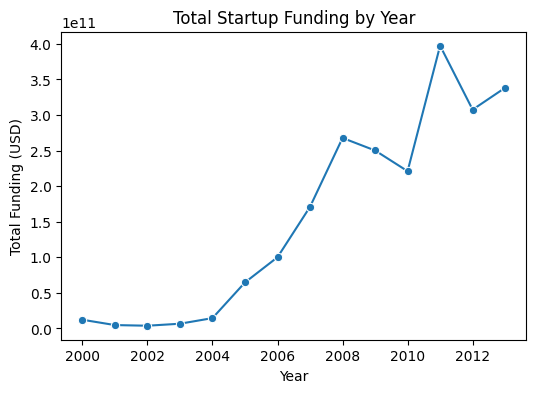

In [106]:
yearly = df3.groupby('year')['raised_amount_usd'].sum().reset_index()
plt.figure(figsize=(6,4))
sns.lineplot(x='year', y='raised_amount_usd', data=yearly, marker='o')
plt.title("Total Startup Funding by Year")
plt.xlabel("Year")
plt.ylabel("Total Funding (USD)")
plt.show()

#### Bar plot: Top 10 industries by total funding

The startups in mobile and software industry has dominate the total funding amount. This aligns with the long-term trends of digital transformation driving investor interest the most. Also, the top three industries were more mature. Investors will have more confidence in more mature industries, so the amount of investment will be more than in new industries.

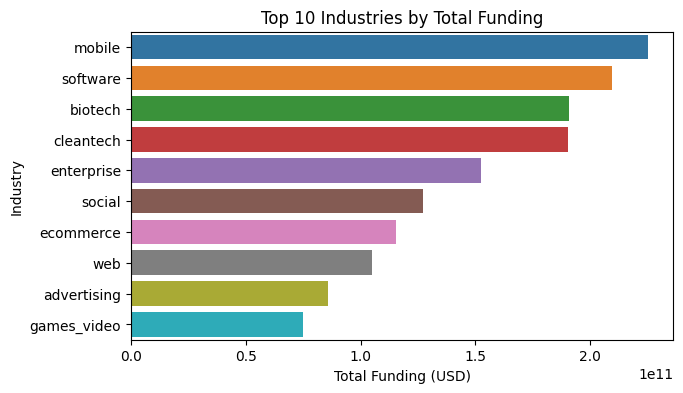

In [107]:
top_industries = df3.groupby('category_code')['raised_amount_usd'].sum().nlargest(10).reset_index()
plt.figure(figsize=(7,4))
sns.barplot(x='raised_amount_usd', y='category_code', data=top_industries, hue='category_code', dodge=False)
plt.title("Top 10 Industries by Total Funding")
plt.xlabel("Total Funding (USD)")
plt.ylabel("Industry")
plt.show()

#### Scatter Plot

Industries like biotech, medical, and news — though often considered low-risk or socially essential — appear at the bottom of the average funding spectrum, suggesting that while they attract consistent support, they are not the largest recipients per startup

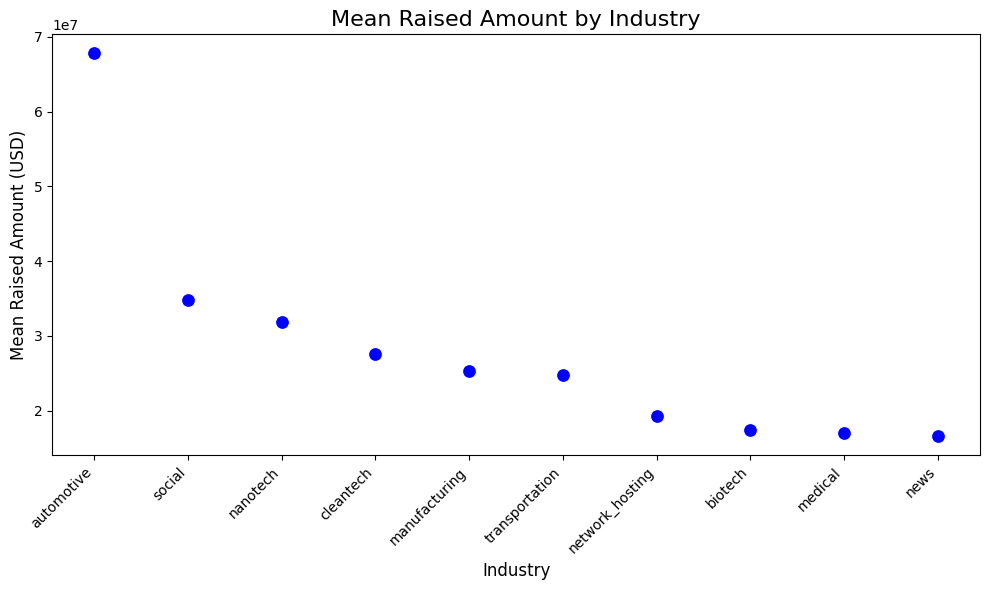

In [108]:
industry_means = df4.groupby('category_code')['raised_amount_usd'].mean().nlargest(10).reset_index()

# Plot the scatter plot
plt.figure(figsize=(10, 6))
sns.scatterplot(data=industry_means, x='category_code', y='raised_amount_usd', color='blue', s=100)

# Customize the plot
plt.title('Mean Raised Amount by Industry', fontsize=16)
plt.xlabel('Industry', fontsize=12)
plt.ylabel('Mean Raised Amount (USD)', fontsize=12)
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

#### Histogram: comparing the total funding in high-risks industries and low-risks industries

According to this histogram, it's easy to find that the funding amount of low-risk industries are more concentrated, with a sharper peak, which indicates greater consistency. The blue bars, representing funds of high-risks industries, is wider spread than low-risks industries. This indicates that high-risk categories have slightly more extreme large values of funding received than low-risks categories. We could conclude that investors' who choose to invest on high-risk categories are being more selective--investing in fewer, but funding heavily once they decided to invest. This might due to the specific patterns of the high-risk investment: the more risky the investment is, the higher rate of return the investor will gain in a short period of time.(Parietti, 2024)

/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/pandas/core/nanops.py:1016: RuntimeWarning: invalid value encountered in subtract
  sqr = _ensure_numeric((avg - values) ** 2)
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/pandas/core/nanops.py:1016: RuntimeWarning: invalid value encountered in subtract
  sqr = _ensure_numeric((avg - values) ** 2)


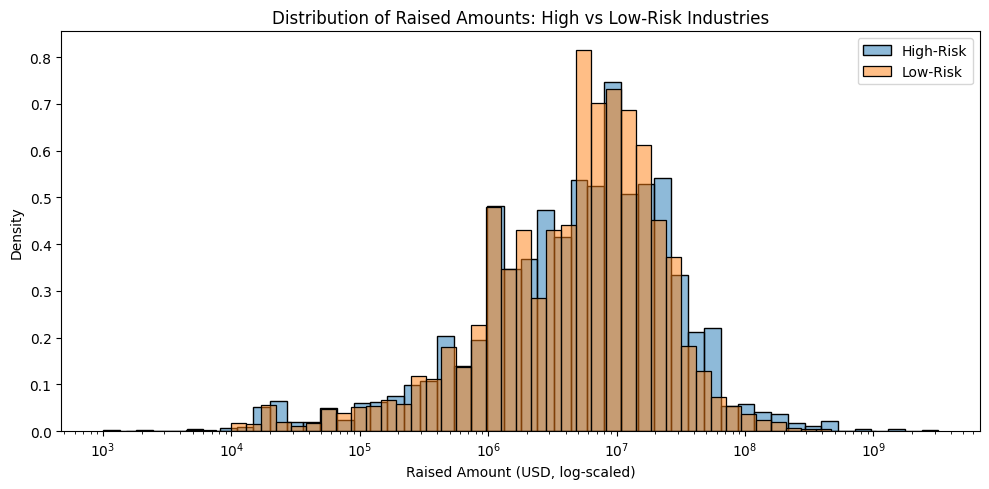

In [109]:
high_risk = df4[df4['Risk_level'] == 'High']['raised_amount_usd']
low_risk = df4[df4['Risk_level'] == 'Low']['raised_amount_usd']

plt.figure(figsize=(10, 5))
sns.histplot(high_risk, label='High-Risk', bins=50, kde=True, stat='density', log_scale=(True, False))
sns.histplot(low_risk, label='Low-Risk', bins=50, kde=True, stat='density', log_scale=(True, False))

plt.title('Distribution of Raised Amounts: High vs Low-Risk Industries')
plt.xlabel('Raised Amount (USD, log-scaled)')
plt.ylabel('Density')
plt.legend()
plt.tight_layout()
plt.show()

#### Heatmap

The heatmap shows the log-scaled average raised amounts by industries(y-axis) and years during recessions(x-axis). This interprets that late-stage startups were prioritize by investors' during economic uncertainties while early-stage startups received lower amount of fundings. The overall trend of investing during recessions preferred late-stage, and low-risks startups. 

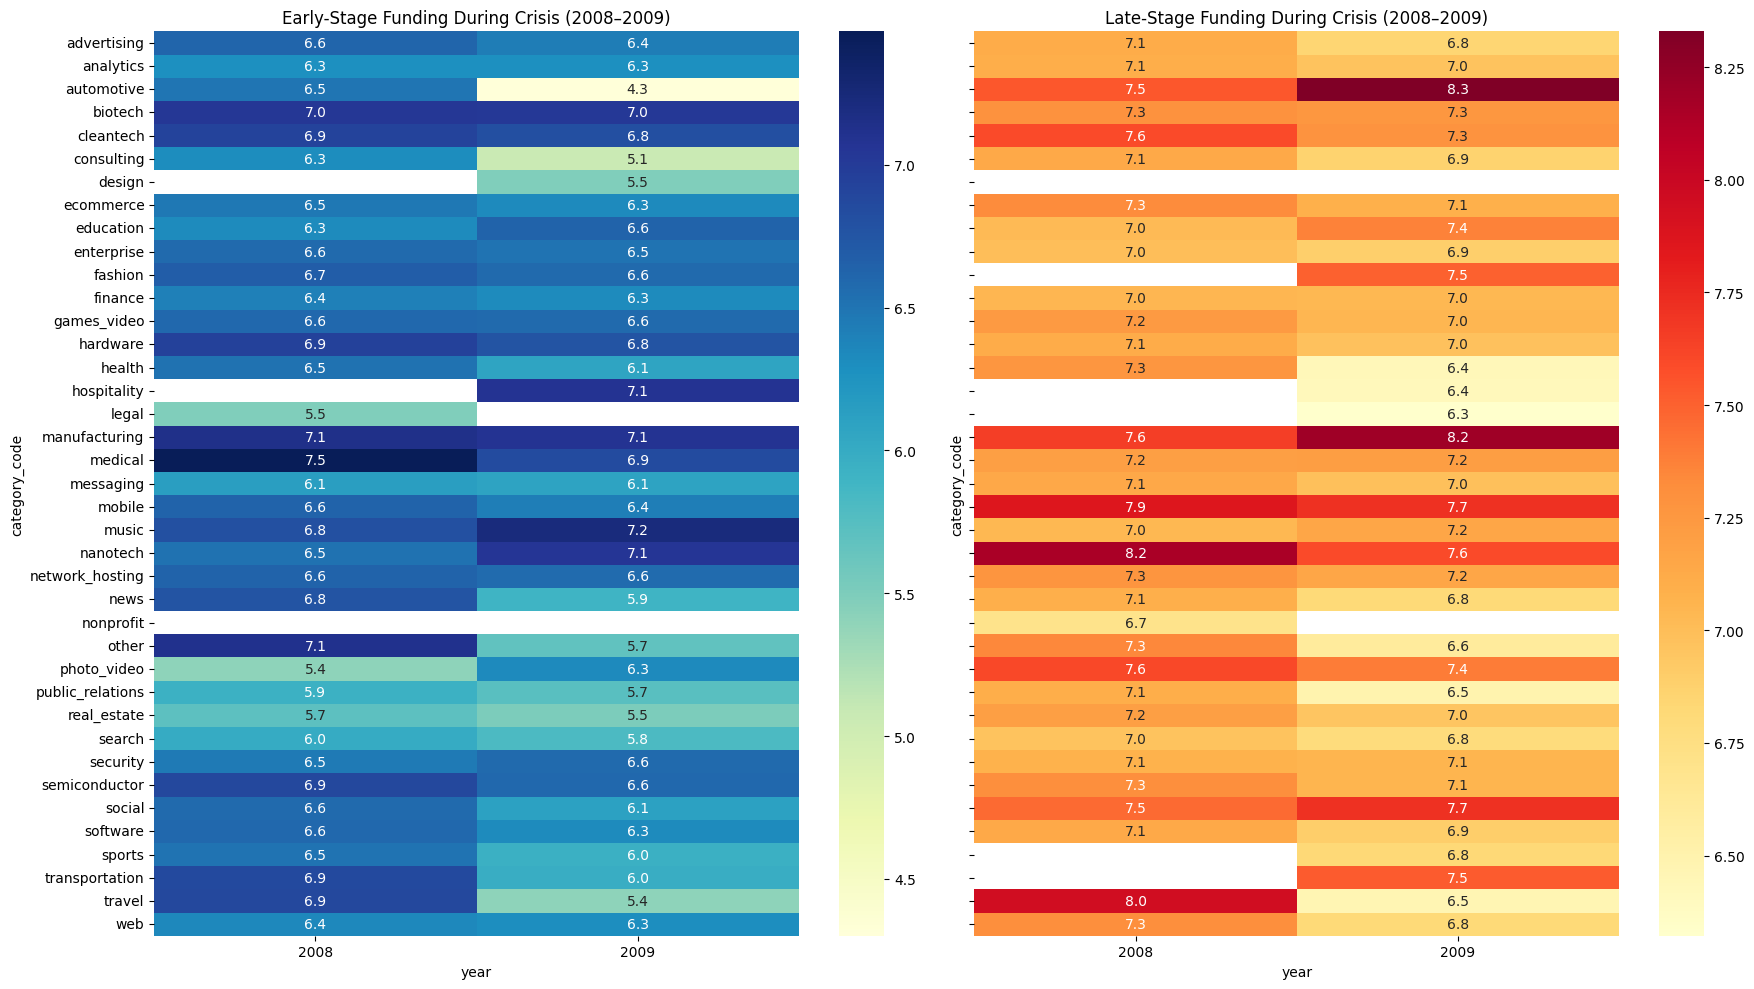

In [110]:
crisis_df = df4[df4['year'].between(2008, 2009)]

early_stage = crisis_df[crisis_df['is_early_stage'] == 1]
late_stage = crisis_df[crisis_df['is_early_stage'] == 0]

early_heatmap = early_stage.pivot_table(
    index='category_code', columns='year', values='raised_amount_usd', aggfunc='mean'
)
late_heatmap = late_stage.pivot_table(
    index='category_code', columns='year', values='raised_amount_usd', aggfunc='mean'
)

early_heatmap = np.log10(early_heatmap.replace(0, np.nan))
late_heatmap = np.log10(late_heatmap.replace(0, np.nan))

fig, axes = plt.subplots(1, 2, figsize=(18, 10), sharey=True)

sns.heatmap(early_heatmap, ax=axes[0], cmap='YlGnBu', annot=True, fmt=".1f")
axes[0].set_title("Early-Stage Funding During Crisis (2008–2009)")

sns.heatmap(late_heatmap, ax=axes[1], cmap='YlOrRd', annot=True, fmt=".1f")
axes[1].set_title("Late-Stage Funding During Crisis (2008–2009)")

plt.tight_layout()
plt.show()

The heatmap below is a simplified version, which points out a significant information that the economic downturns have little to not effect on startups in high-risks industries in both early-stage and late-stage. This one may be a result of the peculiarities of the investment market that investors' have certain biases lead to irrational behaviors such as hiering, loss aversion and overconfidence.(Igual, 2017)

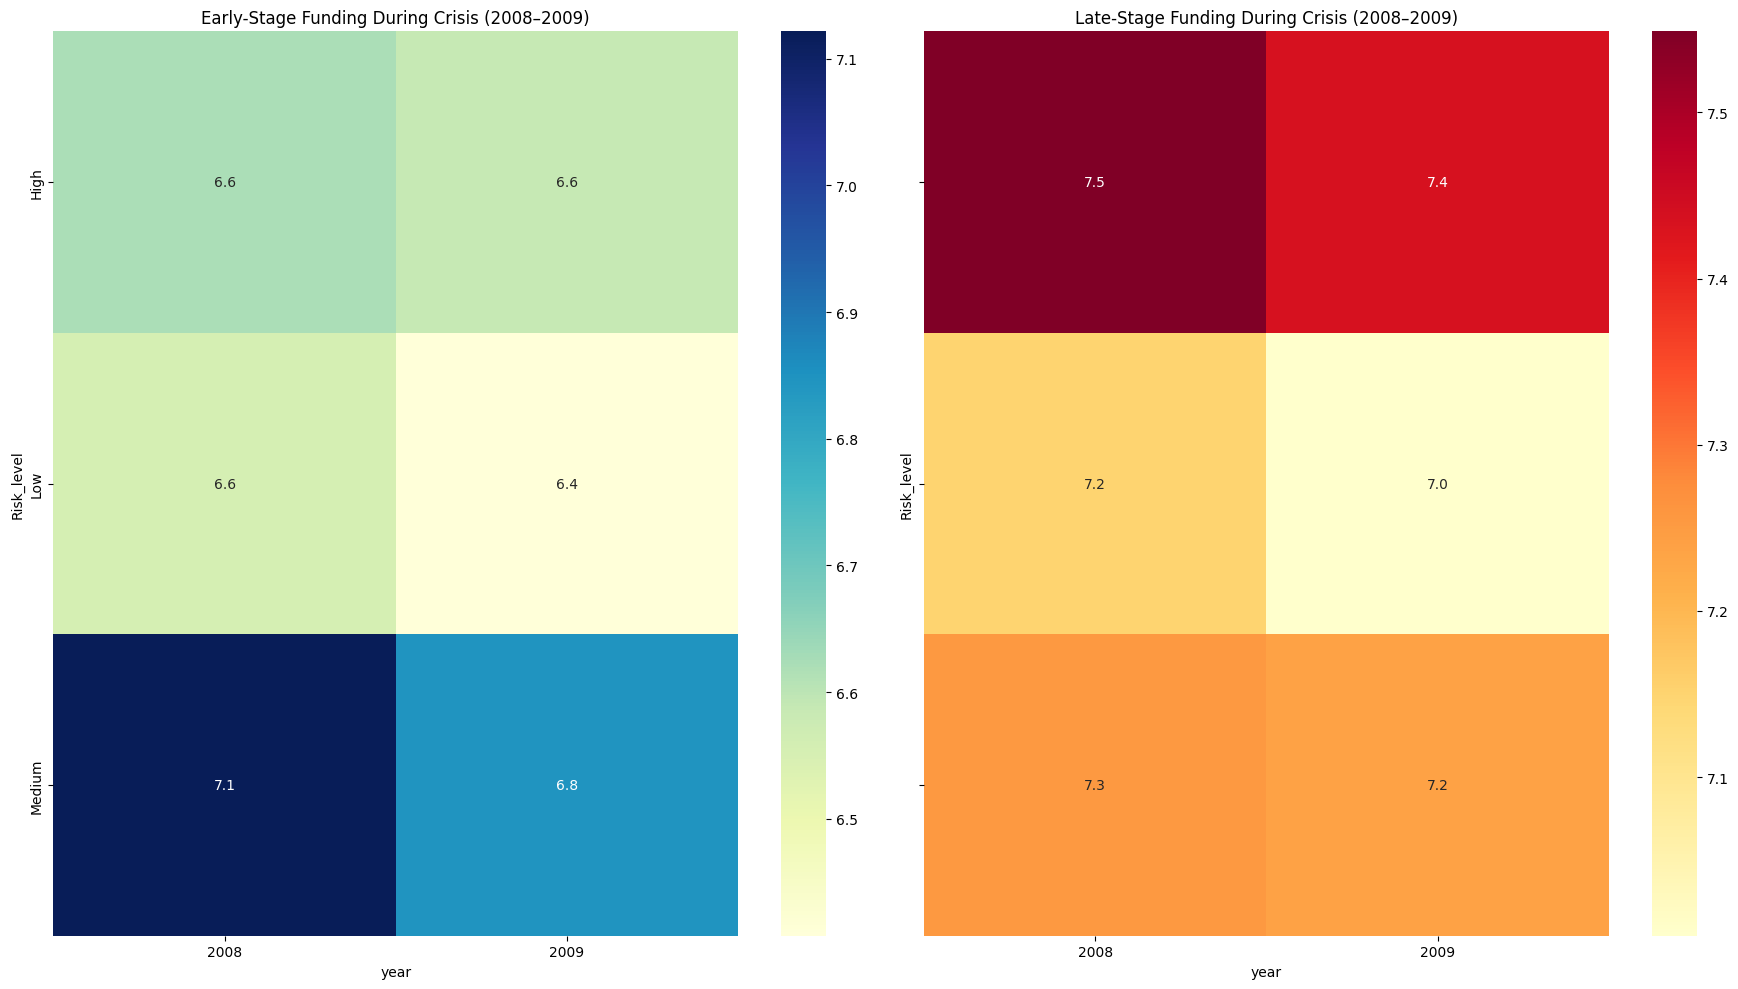

In [111]:
crisis_df = df4[df4['year'].between(2008, 2009)]

early_stage = crisis_df[crisis_df['is_early_stage'] == 1]
late_stage = crisis_df[crisis_df['is_early_stage'] == 0]
high_risk = crisis_df[crisis_df['Risk_level'] == 'High']
low_risk = crisis_df[crisis_df['Risk_level'] == 'Low']

early_heatmap = early_stage.pivot_table(
    index='Risk_level', columns='year', values='raised_amount_usd', aggfunc='mean'
)
late_heatmap = late_stage.pivot_table(
    index='Risk_level', columns='year', values='raised_amount_usd', aggfunc='mean'
)

# Log scale for better readability
early_heatmap = np.log10(early_heatmap.replace(0, np.nan))
late_heatmap = np.log10(late_heatmap.replace(0, np.nan))

fig, axes = plt.subplots(1, 2, figsize=(18, 10), sharey=True)

sns.heatmap(early_heatmap, ax=axes[0], cmap='YlGnBu', annot=True, fmt=".1f")
axes[0].set_title("Early-Stage Funding During Crisis (2008–2009)")

sns.heatmap(late_heatmap, ax=axes[1], cmap='YlOrRd', annot=True, fmt=".1f")
axes[1].set_title("Late-Stage Funding During Crisis (2008–2009)")

plt.tight_layout()
plt.show()

#### Pie chart: Percentage of fundings of each funding stage

Series-C+ rounds dominate 41.2% of total funding. These are typically late-stage investments into more mature startups, which could be considered as lower-risks than other early-stage startups in the same category. The minimal funding in angel and seed stage might due to the economic uncertainty following by the downturns, or lack of data.

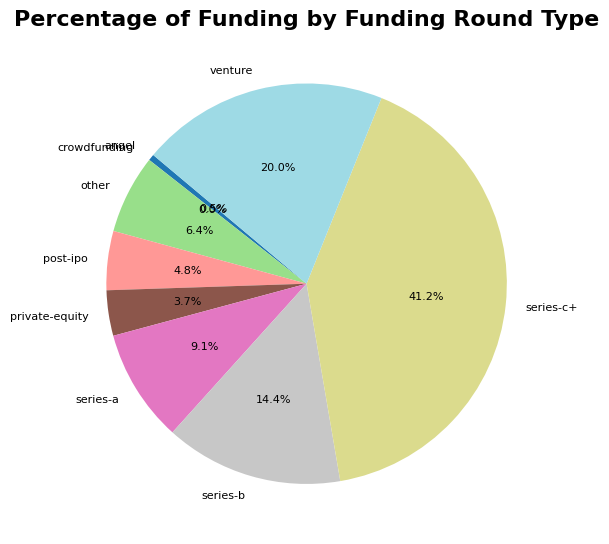

In [112]:
funding_percentage = df4.groupby('funding_round_type')['raised_amount_usd'].sum()
funding_percentage = (funding_percentage / funding_percentage.sum()) * 100

plt.figure(figsize=(6, 6))
funding_percentage.plot(
    kind='pie',
    autopct='%1.1f%%',
    startangle=140,
    cmap='tab20',
    textprops={'fontsize': 8} 
)

plt.title('Percentage of Funding by Funding Round Type', fontsize=16, fontweight='bold')
plt.ylabel('')
plt.tight_layout()
plt.show()

#### Bar plot: Investment amount of different risk level

The low risks investments consistently received the highest amount of funds, especially between 2010 to 2013, which suggests that investors leaned towards safer bets. This might due to 2008 financial crisis and the risk-averse behavior that followed. However, this might also due to the technology development throughout this timeline anf other factors such as more data were collected. This figures supports the hypothesis that investors tend to invest startups in low-risks categories overall, especially during economic downturn periods. Meanwhile, the investments in high-risk ventures were still pursured. 

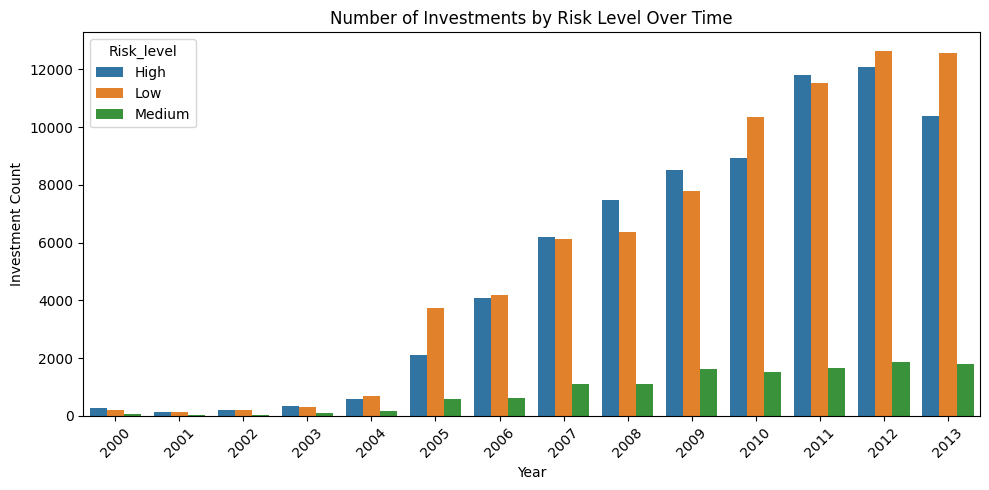

In [113]:
risk_count = merged_df.groupby(['year', 'Risk_level'])['raised_amount_usd'].count().reset_index(name='investment_count')

plt.figure(figsize=(10, 5))
sns.barplot(data=risk_count, x='year', y='investment_count', hue='Risk_level')
plt.title('Number of Investments by Risk Level Over Time')
plt.xlabel('Year')
plt.ylabel('Investment Count')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

## Project 2

### The message

High-risk investments are more volatile than low-risk ones, especially during financial crises, where as low-risk investments showed a smoother upward trend.

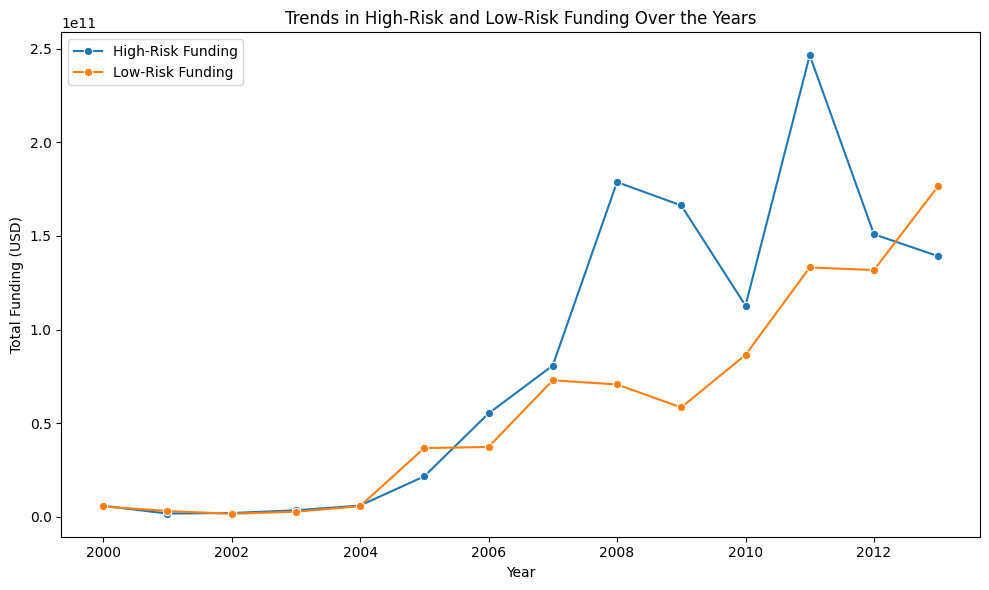

In [114]:
risk_trends = df4.groupby(['year', 'Risk_level'])['raised_amount_usd'].sum().reset_index()
risk_trends_pivot = risk_trends.pivot(index='year', columns='Risk_level', values='raised_amount_usd')

plt.figure(figsize=(10, 6))
sns.lineplot(data=risk_trends_pivot['High'], label='High-Risk Funding', marker='o')
sns.lineplot(data=risk_trends_pivot['Low'], label='Low-Risk Funding', marker='o')

plt.title('Trends in High-Risk and Low-Risk Funding Over the Years')
plt.xlabel('Year')
plt.ylabel('Total Funding (USD)')
plt.legend()
plt.tight_layout()
plt.show()

### Maps and Interpretations

In [115]:
# %pip install geopandas

import geopandas as gpd
from shapely.geometry import Point

world = gpd.read_file('/Users/zzybollar/Downloads/ne_110m_admin_0_countries/ne_110m_admin_0_countries.shp')
world["SOV_A3"] = world["SOV_A3"].replace({
    "US1": "USA", "CH1": "CHN", "NL1": "NLD", "NZ1": "NZL","AU1": "AUS", "GB1": "GBR", "IS1": "ISL",
    "FI1": "FIN","DN1": "DNK", "IE1": "IRL", "NO1": "NOR", "PT1": "PRT", "ES1": "ESP", "SE1": "SWE",
})

North America, parts of Europe, and Australia have higher proportions of total investment allocated to high-risk sectors. india, parts of Africa have higher proportions of total investment allocated to low-risk sectors. This differentiation illustrates that investment preference varies globally. And the possible reason of this difference might due to the policy and market structure difference between countries.

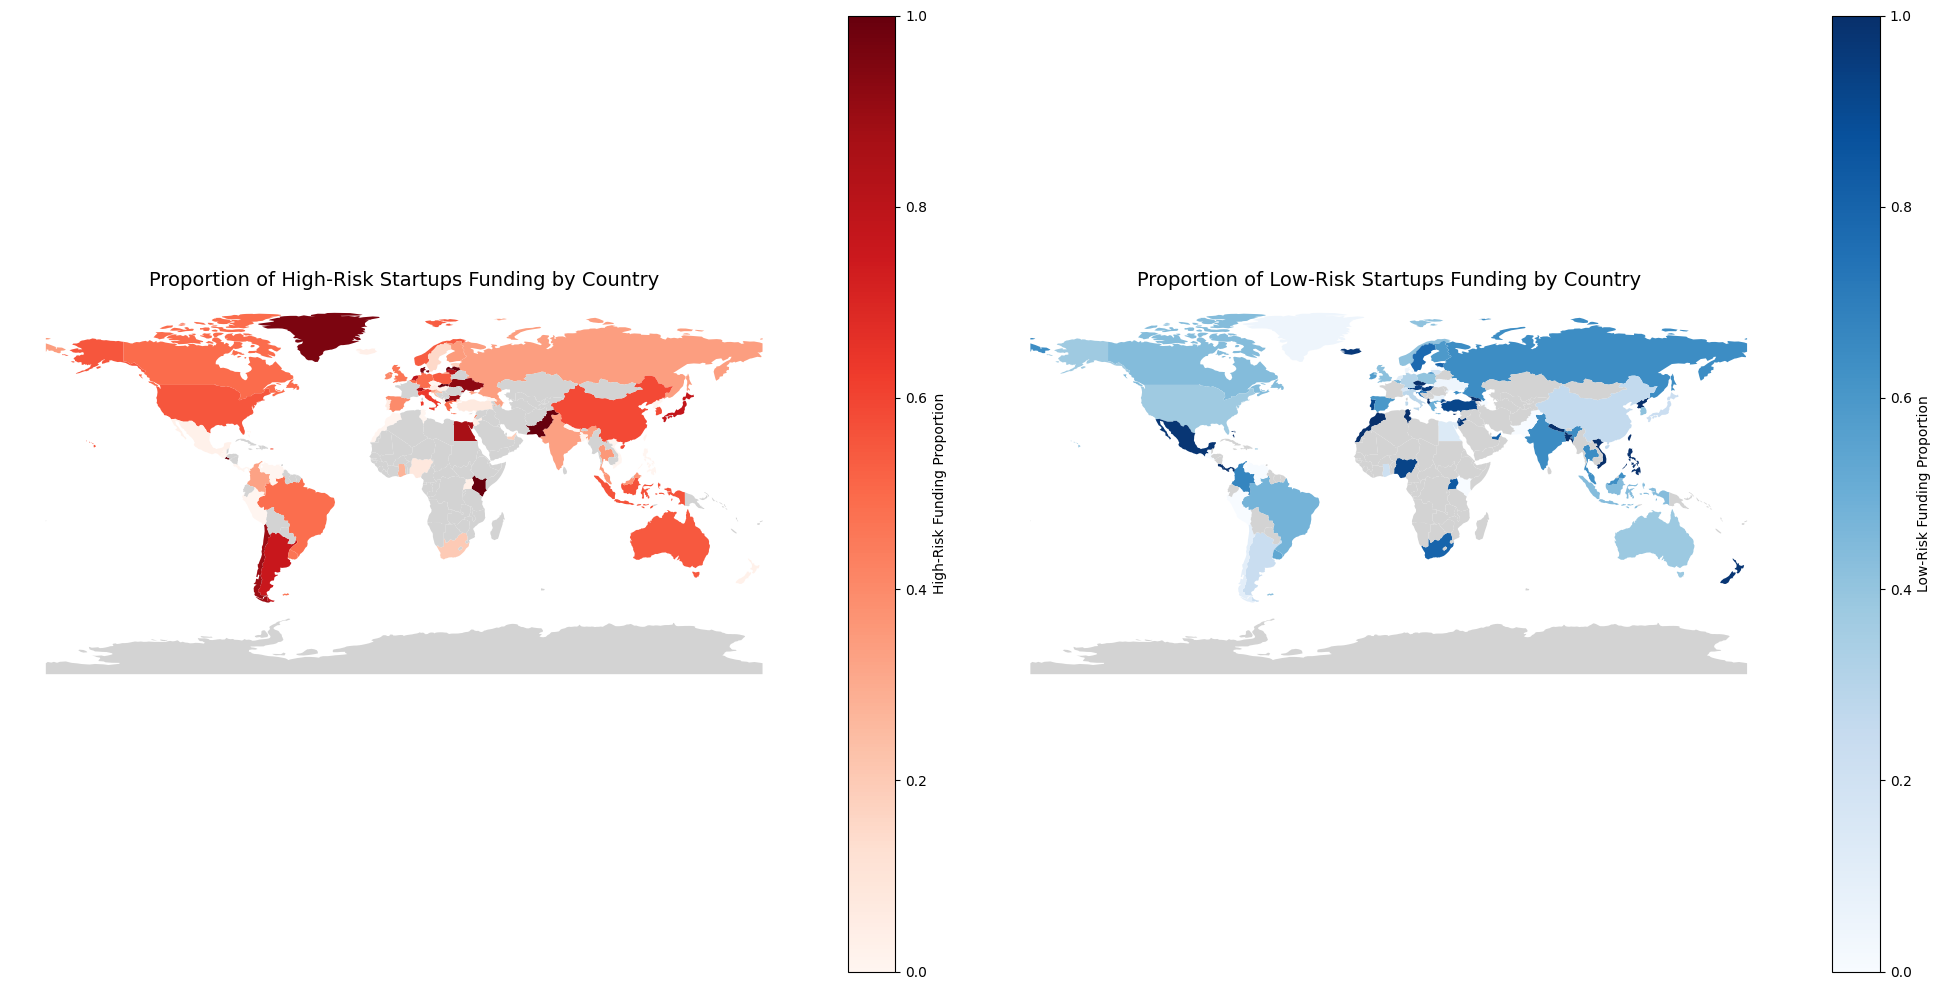

In [116]:
funding_by_country = df4.groupby(['country_code', 'Risk_level'])['raised_amount_usd'].sum().unstack(fill_value=0)
funding_by_country['high_risk_proportion'] = funding_by_country['High'] / funding_by_country.sum(axis=1)
funding_by_country['low_risk_proportion'] = funding_by_country['Low'] / funding_by_country.sum(axis=1)

world_high = world.merge(funding_by_country['high_risk_proportion'], left_on='SOV_A3', right_on='country_code', how='left')
world_low = world.merge(funding_by_country['low_risk_proportion'], left_on='SOV_A3', right_on='country_code', how='left')

fig, axes = plt.subplots(1, 2, figsize=(20, 10))

world_high.plot(column='high_risk_proportion', cmap='Reds', legend=True, 
                missing_kwds={"color": "lightgrey"}, ax=axes[0], 
                legend_kwds={'label': "High-Risk Funding Proportion"})
axes[0].set_title('Proportion of High-Risk Startups Funding by Country', fontsize=14)
axes[0].axis('off')

world_low.plot(column='low_risk_proportion', cmap='Blues', legend=True, 
               missing_kwds={"color": "lightgrey"}, ax=axes[1], 
               legend_kwds={'label': "Low-Risk Funding Proportion"})
axes[1].set_title('Proportion of Low-Risk Startups Funding by Country', fontsize=14)
axes[1].axis('off')

plt.tight_layout()
plt.show()

The geographic maps on the left side interpretes the proportion of early-stage startups in each country. The darker parts are parts of South America, Africa. Several reasons that they have greater proportion of startups:

    1, These countries are emerging economies, which startups is not as mature as other developed countries and China.
    
    2, The total number of startups is not as many as US and Europe
However, by combining with the map on the right side, it's not hard to find that even North America and China has relative low proportion of earty-stage startups, the startups in this geographic area still receive highest investments. This interprets that capital tend to favor regions perceived as more stable or scalable.

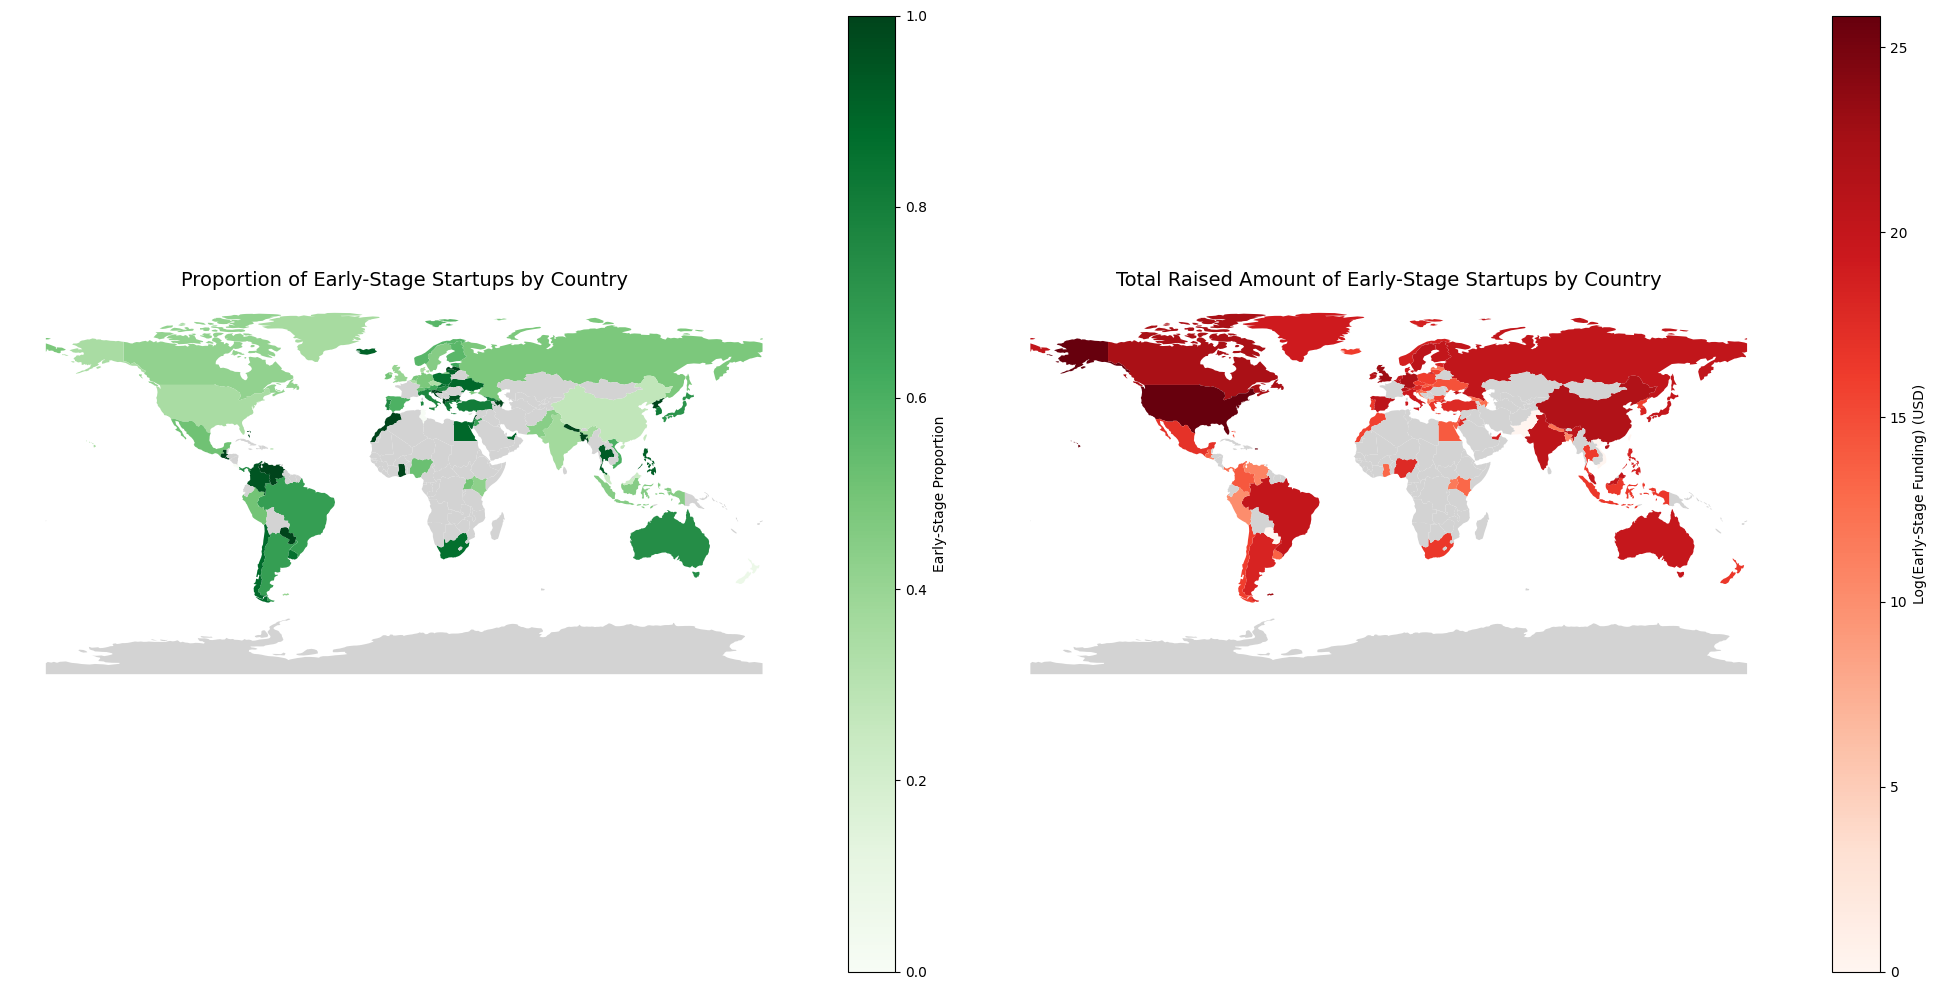

In [117]:
proportions = df4.groupby('country_code').agg(
    total_startups=('is_early_stage', 'count'),
    early_stage_startups=('is_early_stage', 'sum')
).reset_index()
proportions['early_stage_proportion'] = proportions['early_stage_startups'] / proportions['total_startups']

early_stage_funding = df4[df4['is_early_stage']].groupby('country_code')['raised_amount_usd'].sum().reset_index()
early_stage_funding.rename(columns={'raised_amount_usd': 'early_stage_funding'}, inplace=True)
early_stage_funding['log_early_stage_funding'] = np.log1p(early_stage_funding['early_stage_funding'])

world_proportions = world.merge(proportions[['country_code', 'early_stage_proportion']], 
                                left_on='SOV_A3', right_on='country_code', how='left')
world_funding = world.merge(early_stage_funding, left_on='SOV_A3', right_on='country_code', how='left')

fig, axes = plt.subplots(1, 2, figsize=(20, 10))

world_proportions.plot(column='early_stage_proportion', cmap='Greens', legend=True, 
                       missing_kwds={"color": "lightgrey"}, ax=axes[0], 
                       legend_kwds={'label': "Early-Stage Proportion"})
axes[0].set_title('Proportion of Early-Stage Startups by Country', fontsize=14)
axes[0].axis('off')

world_funding.plot(column='log_early_stage_funding', cmap='Reds', legend=True, 
                   missing_kwds={"color": "lightgrey"}, ax=axes[1], 
                   legend_kwds={'label': "Log(Early-Stage Funding) (USD)"})
axes[1].set_title('Total Raised Amount of Early-Stage Startups by Country', fontsize=14)
axes[1].axis('off')

plt.tight_layout()
plt.show()

### Regressions

#### Regression table 1: Early vs. Risky Investment Behavior

This is a regression equation for regression table 1:
$$
logRaisedAmount = \beta_0 + \beta_1 \times \text{is early stage} + \beta_2 \times \text{High-risk} + \beta_3 \times \text{Low-risk}+\beta_4\times\text{is early stage×High-risk} + \beta_5 \times \text{is early stage×Low-risk}+\epsilon
$$

Summary:

Early-stage startups tend to receive slightly less fundings, indicated by the negative coefficient on is_early_stage.The interative term "is_early_stage_High_risk" is positive, which implies some early-stage startups in more risky industries may actually benefit more. This probably due to investor expectations of higher returns of fundings. 
The $R^2$ is low, which is likely due to nonlinear effect, reveals that the funding decisions are likely driven by more complex or unmeasure factors such as the investors' psychology and global political factors.

The results confirm that while more venture capital increases startup funding, the returns diminish over time. Higher interest rates reduce funding, while greater government support and market openness significantly increase it. In other words, during downturns, investors are more confident in funding when macroeconomic signals reduce risk, such as strong policy support or liberalized markets.

In [118]:
from stargazer.stargazer import Stargazer
from IPython.core.display import HTML

np.random.seed(42)
n = 500

data = pd.DataFrame({
    'is_early_stage': np.random.choice([0, 1], size=n),
    'risk_level': np.random.choice(['High-risk', 'Low-risk', 'Medium-risk'], size=n, p=[0.3, 0.5, 0.2]),
    'raised_amount': np.random.normal(loc=100000, scale=50000, size=n).clip(0, 1e6)
})

risk_level_dummies = pd.get_dummies(data['risk_level'], drop_first=False)
risk_level_dummies = risk_level_dummies.astype(int)

data = pd.concat([data, risk_level_dummies], axis=1)
data['log_raised_amount'] = np.log1p(data['raised_amount'])
data['raised_amount'] = np.random.normal(loc=100000, scale=50000, size=n)

data['is_early_stage_High_risk'] = data['is_early_stage'] * data['High-risk']
data['is_early_stage_Low_risk'] = data['is_early_stage'] * data['Low-risk']

X1 = sm.add_constant(data[['is_early_stage']])
X2 = sm.add_constant(data[['is_early_stage', 'High-risk','Low-risk']])
X3 = sm.add_constant(data[['is_early_stage', 'High-risk','Low-risk',
                           'is_early_stage_High_risk']])
X4 = sm.add_constant(data[['is_early_stage', 'High-risk','Low-risk', 'is_early_stage_High_risk', 
                           'is_early_stage_Low_risk']])
y = data['log_raised_amount']

model1 = sm.OLS(y, X1).fit()
model2 = sm.OLS(y, X2).fit()
model3 = sm.OLS(y, X3).fit()
model4 = sm.OLS(y, X4).fit()

stargazer = Stargazer([model1, model2, model3, model4])
stargazer.covariate_order([
    'const',
    'is_early_stage', 'High-risk','Low-risk', 
    'is_early_stage_High_risk', 'is_early_stage_Low_risk', 
    ])
stargazer.custom_columns(['Model 1', 'Model 2', 'Model 3', 'Model 4'], [1] * 4)
stargazer.title("Regression Results: Impact of Economic and Country Factors on Funding")
html_output = stargazer.render_html()
display(HTML(html_output))


#### Regression table 2: Macroeconomic and VC factors

This regression table summaries that higher real interest rates are associated with lower total funding, the funding given by venture capitals has a diminishing returns. The positive relationship of venture investment to total amount might due to 2 reasons:

    1, Large amount of VC investments

    2, Hiering bahavior for individual and small investors

Also, government transfers/subsidies and market openness significant and positive effect on total raised amount. This highlights 2 points:

    1, The government support could possibly reduce perceived risks by providing subsidies to local startups.

    2, Greater market openness lower the barriers for investments, this increases investors' confidence which lead to an increase in total raised amount either by attracting more investors or by the increase in funding amount received from specific investor.

In [119]:
data1 = df4.copy()

data1['Real interest rate (%)'] = pd.to_numeric(data1['Real interest rate (%)'], errors='coerce')
data1['Transfers and subsidies'] = pd.to_numeric(data1['Transfers and subsidies'], errors='coerce')
data1['venture_funding_sum'] = pd.to_numeric(data1['venture_funding_sum'], errors='coerce')
data1['Economic Freedom Summary Index'] = pd.to_numeric(data1[' Economic Freedom Summary Index'], errors='coerce')
data1['Government consumption'] = pd.to_numeric(data1['Government consumption'], errors='coerce')
data1['Market openness'] = pd.to_numeric(data1['Market openness'], errors='coerce')
data1['Tax compliance'] = pd.to_numeric(data1['Tax compliance'], errors='coerce')

data1['venture_funding_sum_sq'] = data1['venture_funding_sum'] ** 2
data1['log_funding_total'] = np.log1p(data1['raised_amount_usd'])

data1 = data1.replace([np.inf, -np.inf], np.nan)
data1 = data1.dropna(subset=['Real interest rate (%)', 'venture_funding_sum', 'venture_funding_sum_sq', 
                             'Transfers and subsidies', 'Market openness', 'log_funding_total'])

X5 = sm.add_constant(data1[['Real interest rate (%)']])
X6 = sm.add_constant(data1[['Real interest rate (%)', 'venture_funding_sum', 'venture_funding_sum_sq']])
X7 = sm.add_constant(data1[['Real interest rate (%)', 'venture_funding_sum', 'venture_funding_sum_sq', 
                            'Transfers and subsidies']])
X8 = sm.add_constant(data1[['Real interest rate (%)', 'venture_funding_sum', 'venture_funding_sum_sq', 
                            'Transfers and subsidies', 'Market openness']])

y1 = data1['log_funding_total']

model5 = sm.OLS(y1, X5).fit()
model6 = sm.OLS(y1, X6).fit()
model7 = sm.OLS(y1, X7).fit()
model8 = sm.OLS(y1, X8).fit()

stargazer = Stargazer([model5, model6, model7, model8])
stargazer.covariate_order([
    'const',
    'Real interest rate (%)', 'venture_funding_sum', 'venture_funding_sum_sq', 
    'Transfers and subsidies', 'Market openness'
])
stargazer.custom_columns(['Model 5', 'Model 6', 'Model 7', 'Model 8'], [1] * 4)
stargazer.title("Regression Results: Impact of Economic and VC Funding Factors on Funding")
html_output = stargazer.render_html()
display(HTML(html_output))

/var/folders/lh/v36j2zlj0t9_xqpxcj3l9qfw0000gn/T/ipykernel_43512/278385850.py:14: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  data1 = data1.replace([np.inf, -np.inf], np.nan)


## Final project

### Potential data to scrape

In [120]:
import requests
url = 'https://news.crunchbase.com/emerging-unicorn-list/'
headers = {'User-Agent': 'Mozilla/5.0'}
response = requests.get(url, headers=headers)
print("Status Code:", response.status_code)

Status Code: 200


### Potential Challenge

The table in this website is not the simple HTML code. It has to use the method of selenium since it's in Javascript.

### Scrapping data from a website

In [121]:
from selenium import webdriver
from selenium.webdriver.chrome.options import Options
from selenium.webdriver.common.by import By
from selenium.webdriver.chrome.service import Service
import pandas as pd
import time

options = Options()
options.add_argument("--headless") 
options.add_argument("--disable-gpu")
options.add_argument("--window-size=1920,1080")

service = Service("/opt/homebrew/bin/chromedriver") 
driver = webdriver.Chrome(service=service, options=options)

try:
    url = "https://news.crunchbase.com/emerging-unicorn-list/"
    driver.get(url)

    time.sleep(8) 

    driver.execute_script("window.scrollTo(0, document.body.scrollHeight);")
    time.sleep(3)

    rows = driver.find_elements(By.CSS_SELECTOR, "table tbody tr")

    data = []

    for row in rows:
        try:
            cells = row.find_elements(By.TAG_NAME, "td")
            if len(cells) >= 6:
                company_name = cells[0].text.strip()
                post_money_value = cells[1].text.strip()
                total_equity_funding = cells[2].text.strip()
                lead_investors = cells[3].text.strip()
                country = cells[4].text.strip()
                continent = cells[5].text.strip()

                data.append({
                    "Company Name": company_name,
                    "Post Money Value": post_money_value,
                    "Total Equity Funding": total_equity_funding,
                    "Lead Investors": lead_investors,
                    "Country": country,
                    "Continent": continent
                })
        except Exception as e:
            print("Row skipped due to error:", e)

    df7 = pd.DataFrame(data)
    df7.to_csv("emerging_unicorns.csv", index=False)
    print("Data saved to emerging_unicorns.csv")
    print(df7.head())

finally:
    driver.quit()

def clean_money(value):
    if isinstance(value, str):
        value = value.replace('$', '').replace('M', '').strip()
        if value == '' or value == '0':
            return 0.0
        try:
            return float(value)
        except:
            return None
    return value

df7['Post Money Value (M)'] = df7['Post Money Value'].apply(clean_money)
df7['Total Equity Funding (M)'] = df7['Total Equity Funding'].apply(clean_money)

df7 = df7[['Company Name', 'Post Money Value (M)', 'Total Equity Funding (M)','Lead Investors','Country','Continent']]
df7.to_csv("emerging_unicorns_cleaned.csv", index=False)
df7 = pd.read_csv("emerging_unicorns_cleaned.csv")

Data saved to emerging_unicorns.csv
     Company Name Post Money Value Total Equity Funding     Lead Investors  \
0  Changyang Tech            $990M                $125M       Ally Capital   
1          Tustin            $986M                   $0                HSG   
2      Nxtra Data            $986M                $237M  The Carlyle Group   
3   Butternut Box            $985M                $467M   General Atlantic   
4         Bizongo            $980M                $295M     Schroder Adveq   

          Country Continent  
0           China      Asia  
1           China      Asia  
2           India      Asia  
3  United Kingdom    Europe  
4           India      Asia  


In [122]:
df7.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 451 entries, 0 to 450
Data columns (total 6 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Company Name              451 non-null    object 
 1   Post Money Value (M)      451 non-null    float64
 2   Total Equity Funding (M)  449 non-null    float64
 3   Lead Investors            432 non-null    object 
 4   Country                   451 non-null    object 
 5   Continent                 451 non-null    object 
dtypes: float64(2), object(4)
memory usage: 21.3+ KB


### Visualizing the Scraped dataset

The scraped dataset contains datas for 451 emerging unicorn companies for recent years.(Emerging unicorn company list: Crunchbase 2023) North America(especially the U.S.) is still considered as both a scalable and relative "safe" econosystem for startups. This is due to the mature financial and innovation systems. This aligns with investor behavior that seeks scalable risks not only during the economic downturns, but in the long-term. Asia stands in a stonger position. This might mainly due to the rapid growth of GDP of China started about 2000. 

/var/folders/lh/v36j2zlj0t9_xqpxcj3l9qfw0000gn/T/ipykernel_43512/614118223.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=continent_funding.index, y=continent_funding.values, palette='viridis')


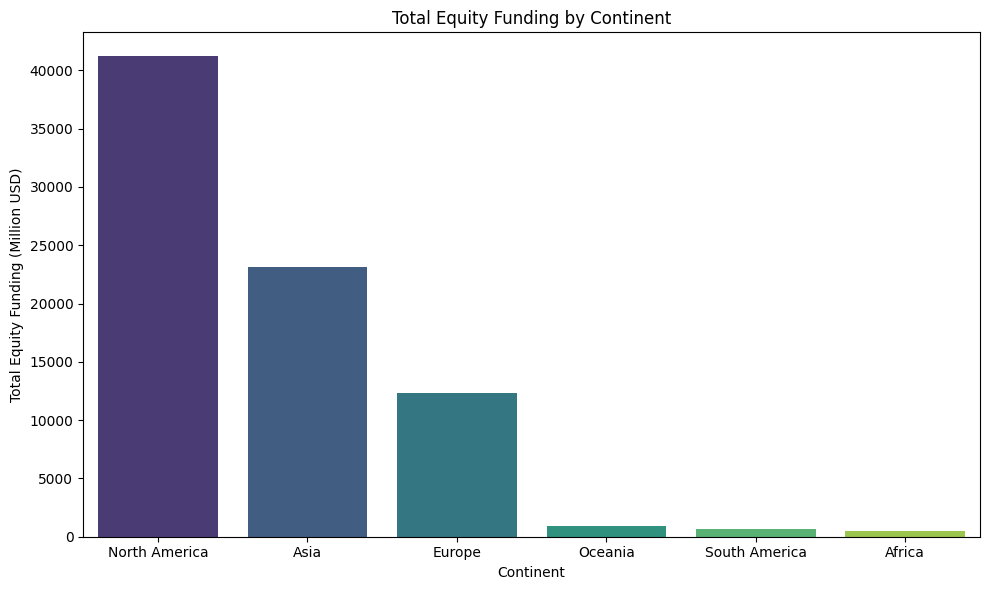

In [123]:
continent_funding = df7.groupby('Continent')['Total Equity Funding (M)'].sum().sort_values(ascending=False)

# Plot total equity funding by continent
plt.figure(figsize=(10, 6))
sns.barplot(x=continent_funding.index, y=continent_funding.values, palette='viridis')
plt.title('Total Equity Funding by Continent')
plt.ylabel('Total Equity Funding (Million USD)')
plt.xlabel('Continent')
plt.tight_layout()
plt.show()

### Regression Tree

#### 1-Decision tree

The key takeaways of the classification tree is that high government subsidies and late-stage startups increase the change of high funding, where as low-risk startups tend to receive lower fundings. This suggests that the scalable risk attracts investors during recovery. According to these interpretations, we could summarize certain conclusions:

1, Low-risk industries have a larger number of investors, while high-risk industries have a smaller number of investors but a larger amount of individual inputs.
2，Rather than simply analyzing the shift in investor bias between sectors with different risk profiles, there is a greater tendency to invest strategically in startups that are supported by the government. Local governments tend to provide more are support to later-stage, lower-risk companies.

/var/folders/lh/v36j2zlj0t9_xqpxcj3l9qfw0000gn/T/ipykernel_43512/968660716.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df4_clean['high_funding'] = df4_clean['raised_amount_usd'] > mean_funding


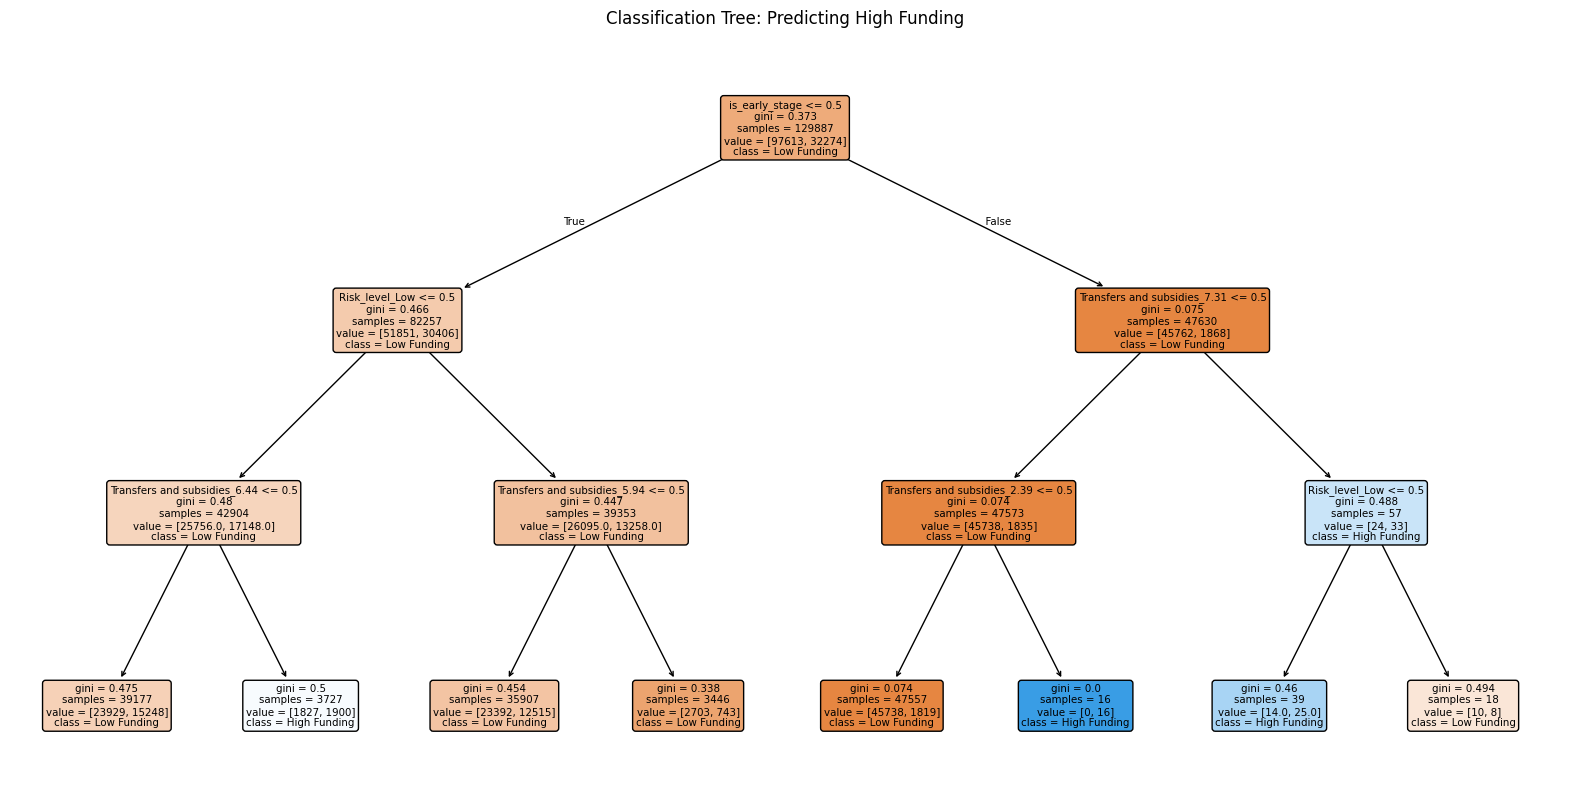

Classification Report:
              precision    recall  f1-score       support
False          0.760538  0.982128  0.857245  24451.000000
True           0.512821  0.057349  0.103162   8021.000000
accuracy       0.753695  0.753695  0.753695      0.753695
macro avg      0.636679  0.519738  0.480203  32472.000000
weighted avg   0.699349  0.753695  0.670977  32472.000000

Confusion Matrix:
[[24014   437]
 [ 7561   460]]


In [124]:
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix

features = ['Risk_level', 'is_early_stage', 'country_code', 'Transfers and subsidies', 'Market openness']
target = 'high_funding'

df4_clean = df4.dropna(subset=features + ['raised_amount_usd'])
if df4_clean.empty:
    raise ValueError("df4_clean is empty after dropping rows with missing values. Check your data.")

mean_funding = df4_clean['raised_amount_usd'].mean()
df4_clean['high_funding'] = df4_clean['raised_amount_usd'] > mean_funding

df4_encoded = pd.get_dummies(df4_clean[features + [target]])

X = df4_encoded.drop(columns=[target])
y2 = df4_encoded[target]

X_train, X_test, y2_train, y2_test = train_test_split(X, y2, test_size=0.2, random_state=42)

clf = DecisionTreeClassifier(max_depth=3, random_state=42)
clf.fit(X_train, y2_train)

plt.figure(figsize=(20, 10))
plot_tree(clf, feature_names=X.columns, class_names=['Low Funding', 'High Funding'], filled=True, rounded=True)
plt.title("Classification Tree: Predicting High Funding")
plt.show()

y2_pred = clf.predict(X_test)
report = classification_report(y2_test, y2_pred, output_dict=True)
conf_matrix = confusion_matrix(y2_test, y2_pred)

print("Classification Report:")
print(pd.DataFrame(report).transpose())
print("\nConfusion Matrix:")
print(conf_matrix)

$$
Error rate = \frac{False Positive + False negatives}{Total Observations} \approx 24.6%
$$

$$
Gini = 1-\sum^{C}_{i=1} (p_{i})^2
$$

$p_{i}$: proportion of samples of class i in the node

#### 2- Regression tree

The regression tree captures the non-linear relationships and policy thresholds like market openness or interest rates.

The objective function of a regression tree is to minimize SSE across all leaves.
The objective function of this regression tree will be:
 $$
\min_{j, s} \left[
\sum_{i : \text{MarketOpenness}_i \leq s} \left( \log(\text{RaisedAmount}_i) - \hat{y}_{R1} \right)^2 +
\sum_{i : \text{MarketOpenness}_i > s} \left( \log(\text{RaisedAmount}_i) - \hat{y}_{R2} \right)^2
\right]
$$
Then recursively repeat for each child region, using split variables like:

TaxCompliance, RealInterestRate, VentureFundingSum, etc.

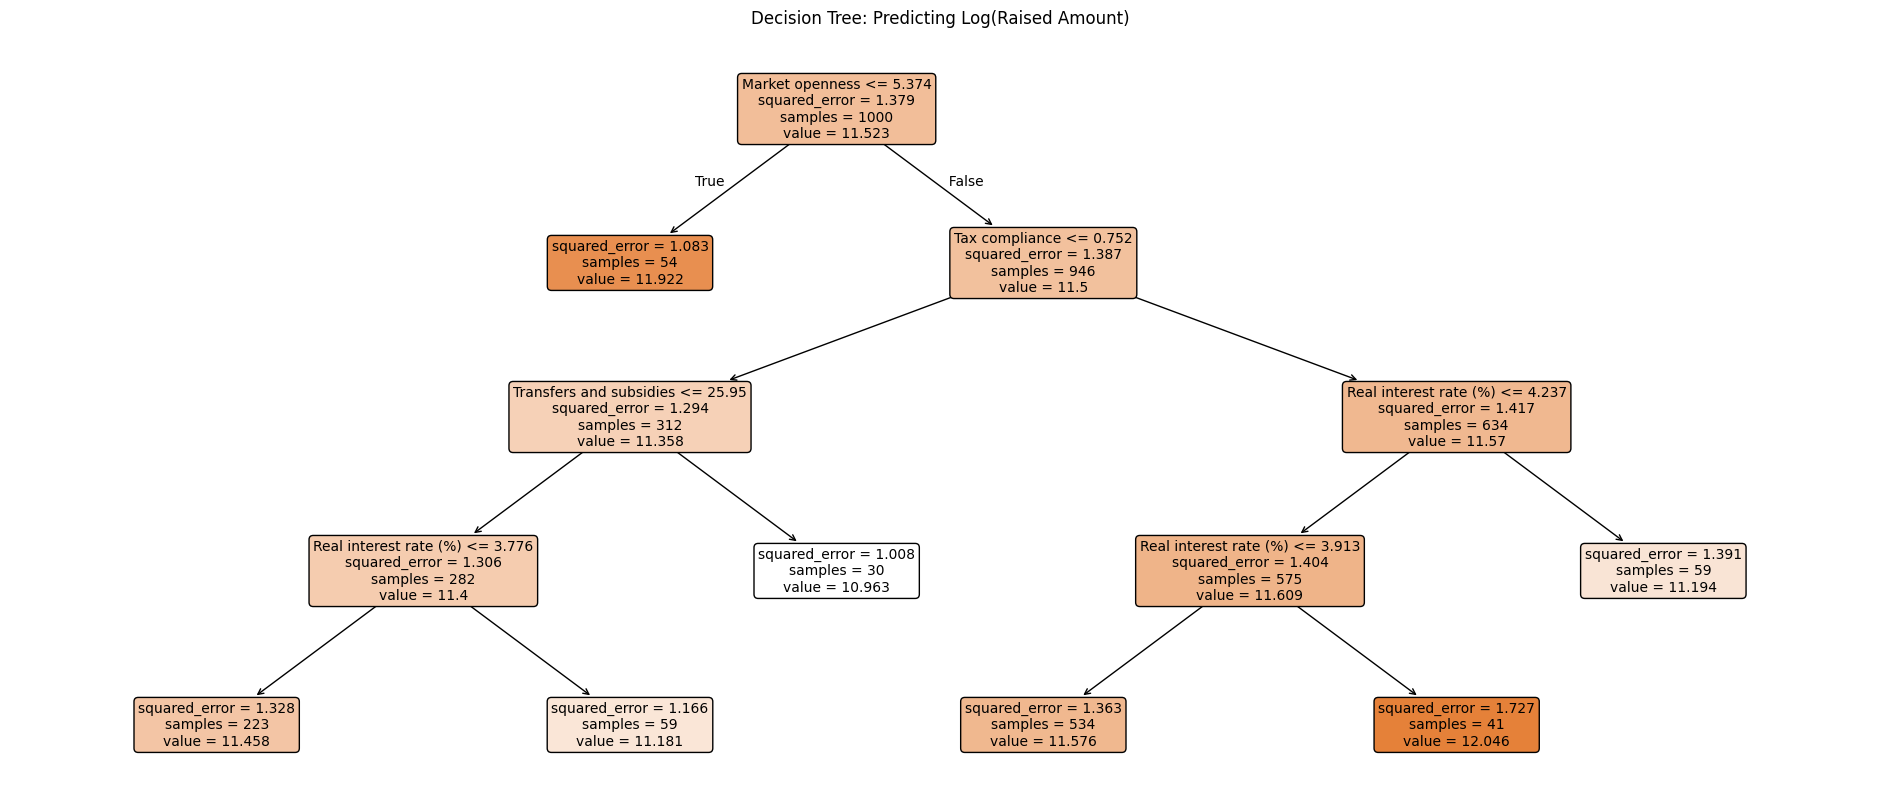

In [125]:
from sklearn.tree import DecisionTreeRegressor, plot_tree

np.random.seed(42)
n = 1000
df_tree = pd.DataFrame({
    'log_raised_amount': np.random.normal(loc=11.5, scale=1.2, size=n),
    'is_early_stage': np.random.choice([0, 1], size=n),
    'High-risk': np.random.choice([0, 1], size=n),
    'Low-risk': np.random.choice([0, 1], size=n),
    'Real interest rate (%)': np.random.normal(loc=3.0, scale=1.0, size=n),
    'venture_funding_sum': np.random.normal(loc=500000, scale=100000, size=n),
    'Transfers and subsidies': np.random.normal(loc=20, scale=5, size=n),
    'Market openness': np.random.normal(loc=7, scale=1, size=n),
    'Tax compliance': np.random.normal(loc=0.8, scale=0.1, size=n)
})
df_tree['venture_funding_sum_sq'] = df_tree['venture_funding_sum'] ** 2

features2 = ['is_early_stage', 'High-risk', 'Low-risk', 
             'Real interest rate (%)', 'venture_funding_sum',
             'venture_funding_sum_sq', 'Transfers and subsidies', 'Market openness','Tax compliance']
features2 = [f for f in features2 if f in df_tree.columns]
rgre_X = df_tree[features2]
rgre_y = df_tree['log_raised_amount']

tree = DecisionTreeRegressor(max_depth=4, min_samples_leaf=30, random_state=42)
tree.fit(rgre_X, rgre_y)

plt.figure(figsize=(24, 10))
plot_tree(tree, feature_names=features2, filled=True, rounded=True, fontsize=10)
plt.title("Decision Tree: Predicting Log(Raised Amount)")
plt.show()


The regularized function is: 
$$
\min_{\text{tree} \in \mathcal{T}} \sum_{i=1}^{n} \left( \log(\hat{y}_i) - \log(y_i) \right)^2 + \alpha \cdot \left| T \right|
$$


$\hat{y}_i$: predicted log of raised amount from the regression tree

$y_i$: actual log of raised amount for observation i

$\alpha$: regularization strength

$|T|$: number of terminal nods

This regularized tree could prevent the overfitting 

### Random Forest

The Random Forest shows that rather than startup itself, the overall economic environmental factors have a more decisive impact on the total amount of investment received. 

In [126]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score

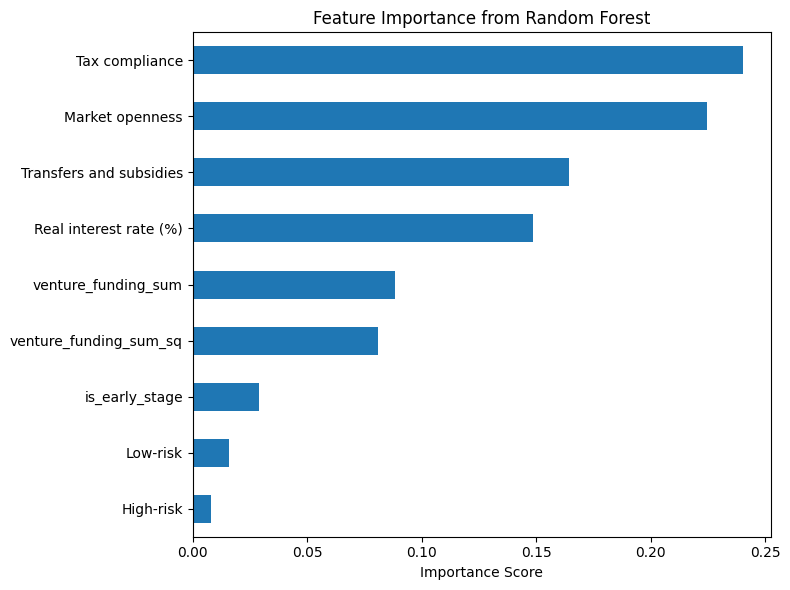

In [127]:
from sklearn.model_selection import train_test_split
X = df_tree[features2]
y = df_tree['log_raised_amount']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

rf_model = RandomForestRegressor(n_estimators=100, max_depth=6, random_state=42)
rf_model.fit(X_train, y_train)

importances = pd.Series(rf_model.feature_importances_, index=features2).sort_values(ascending=True)
y_pred = rf_model.predict(X_test)

mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

plt.figure(figsize=(8, 6))
importances.plot(kind='barh')
plt.title("Feature Importance from Random Forest")
plt.xlabel("Importance Score")
plt.tight_layout()
plt.show()


### OLS vs ML

In [130]:
from sklearn.metrics import accuracy_score, mean_squared_error, r2_score

# Classification tree evaluation
clf_accuracy = accuracy_score(y2_test, y2_pred)

# Regression tree evaluation
rgre_y_pred = tree.predict(rgre_X)
rgre_mse = mean_squared_error(rgre_y, rgre_y_pred)
rgre_r2 = r2_score(rgre_y, rgre_y_pred)

# OLS regression evaluation
X_ols = sm.add_constant(rgre_X)
ols_model = sm.OLS(rgre_y, X_ols).fit()
ols_pred = ols_model.predict(X_ols)
ols_mse = mean_squared_error(rgre_y, ols_pred)
ols_r2 = r2_score(rgre_y, ols_pred)

# Comparison DataFrame
comparison = pd.DataFrame({
    'Model': ['Classification Tree', 'Regression Tree', 'OLS Regression'],
    'Accuracy/MSE/R²': [clf_accuracy, rgre_mse, ols_mse],
    'MSE/R²': [None, rgre_r2, ols_r2]
})
comparison.set_index('Model', inplace=True)

print("Comparison of Regression Tree, Classification Tree and OLS regression table:")
print(comparison)

Comparison of Regression Tree, Classification Tree and OLS regression table:
                     Accuracy/MSE/R²    MSE/R²
Model                                         
Classification Tree         0.753695       NaN
Regression Tree             1.334444  0.032579
OLS Regression              1.367424  0.008670


The OLS model performs worst among three with lowest $R^2$. This is because the linear regression could not capture nonlinear interactions. The tree models better fit with the complex real-world that affects the investors' decisions. Whereas the classification achieves an accurary of 75%, effectively predicting high or low fundings. The tree structure also identifies the exact conditions under which the likelihood of investment increases, thus providing policymakers with more actionable insights.

### Conclusion

There is little doubt that major economic downturns—such as the 2008 financial crisis—reshape the landscape of startup investment. \citep{VCInvestmentStrategies} However, their impact is not primarily a reduction in the total volume of investments. Rather, these events shift how investors assess and allocate capital, changing both the strategy and criteria used to evaluate startups. This study examined how venture capital responds to uncertainty, asking whether global investors favor safer industries or remain drawn to scalable, risk-intensive ventures during economic downturns. Our analysis found a consistent pattern: in periods associated with economic stress, funding became more concentrated in capital-intensive but elastic sectors like biotechnology and enterprise software--suggesting a tilt toward safer bets. These industries offer a combination of stability and long-term value, making them appealing when risk tolerance shrinks, suggesting that investors remain open to scalable risk, particularly when startups demonstrate strong market potential, technological differentiation, or policy alignment.One possible explanation for this dual behavior lies in the psychology of investing. In uncertain environments, the promise of high returns from breakthrough technologies may still entice investors, even if those opportunities come with greater risk. This reflects a common tension in investor behavior: the desire to minimize losses while still capturing rare, high-reward opportunities.

Ultimately, our analysis supports a hybrid conclusion: economic downturns do not eliminate risk appetite—they recalibrate it. Investors become more selective, directing capital toward ventures that not only show promise but also signal resilience. Rather than avoiding entirely from uncertainty, they adapt it—treating it as a filter for more disciplined and strategically timed risk-taking.



## References

Caballero, R., & Kurlat, P. (2008). Flight to quality and bailouts: Policy remarks and a literature review.
, 08–21.

Rajan, R. G. (2011). Fault lines: How hidden fractures still threaten the world economy. princeton University press.

Nanda, R., & Rhodes-Kropf, M. (2013). Investment cycles and startup innovation. Journal of financial economics, 110(2), 403-418.

Samila, S., & Sorenson, O. (2011). Venture capital, entrepreneurship, and economic growth. The Review of Economics and Statistics, 93(1), 338-349.

Chemmanur, T. J., Loutskina, E., & Tian, X. (2014). Corporate venture capital, value creation, and innovation. The Review of Financial Studies, 27(8), 2434-2473.

Instone, S. (2022, August 11). What have we learned from the 2008 financial crisis?. AES International. https://www.aesinternational.com/blog/what-have-we-learned-from-the-2008-financial-crisis 

Gratton, P. (n.d.). The stock market crash of 2008. Investopedia. https://www.investopedia.com/articles/economics/09/subprime-market-2008.asp#:~:text=Collapse%20of%20Major%20Financial%20Institutions&text=Lehman’s%20bankruptcy%20in%202008%20triggered,to%20widespread%20economic%20distress%E2%80%8B. 

Parietti, M. (2024, June 30). 8 high-risk investments that could double your money. Investopedia. https://www.investopedia.com/articles/markets/121515/8-high-risk-investments-could-double-your-money.asp 

Crunchbase. (2023, April 4). Emerging unicorn company list: Crunchbase. Crunchbase News. https://news.crunchbase.com/emerging-unicorn-list/ 


Igual, M. G., & Santamaría, T. C. (2017). Overconfidence, Loss Aversion and Irrational Investor Behavior: A Conceptual Map. Journal of Economic & Management Perspectives, 11(1), 273–290.
